In [1]:
!pip install --upgrade imbalanced-learn
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 101.6 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.9/932.9 kB 16.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 3.1 MB/s eta 0:00

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="k7krLTP9ELURq7rNspoz")
project = rf.workspace("narayana-college").project("waste-classification8k-wephl")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to waste-classification8K-1 in yolov8:: 100%|██████████| 12050/12050 [00:01<00:00, 8439.14it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
import os
import sys
import gc
import time
import shutil
import random
import yaml
import joblib
import torch
import cv2
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from PIL import Image
from IPython.display import YouTubeVideo

# Scikit-learn modules
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, GridSearchCV, 
    train_test_split, RandomizedSearchCV, validation_curve
)
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    accuracy_score, f1_score, roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier

# Image processing and feature extraction
from skimage.feature import local_binary_pattern, hog
from skimage import exposure

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Dense, Activation, Dropout, Conv2D, 
    MaxPooling2D, BatchNormalization
)
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Imbalanced learning techniques
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek

# Parallel processing
from joblib import Parallel, delayed

# YOLO for object detection
from ultralytics import YOLO

# Set TensorFlow log level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set Seaborn style
sns.set_style('darkgrid')

print("All modules have been imported successfully.")


All modules have been imported successfully.


In [5]:
# Define the dataset path
dataset_path = "/kaggle/working/waste-classification8K-1"

# Define old class mappings
old_to_new_classes = {
    0: 0,  # Clothes Waste → Clothes Waste (recyclable)
    1: 1,  # Food Waste → Food - Biodegradable (non_recyclable)
    2: 2,  # Glass → Glass - Non-Biodegradable (recyclable)
    3: 3,  # Hazardous Waste → Hazardous Waste (non_recyclable)
    4: 4,  # Medical Waste → Medical Waste (non_recyclable)
    5: 5,  # Metal → Metal (recyclable)
    6: 6,  # Paper → Paper (recyclable)
    7: 7,  # Plastic → Plastic (recyclable)
    8: 7,  # Plastic → Plastic (recyclable)
    9: 7,  # Plastic → Plastic (recyclable)
}

# Function to update label files
def update_labels(label_folder):
    for label_file in os.listdir(label_folder):
        if label_file.endswith(".txt"):
            label_path = os.path.join(label_folder, label_file)
            with open(label_path, "r") as file:
                lines = file.readlines()

            updated_lines = []
            for line in lines:
                parts = line.split()
                old_class_id = int(parts[0])

                # Map old class ID to new class ID
                if old_class_id in old_to_new_classes:
                    parts[0] = str(old_to_new_classes[old_class_id])

                updated_lines.append(" ".join(parts) + "\n")

            # Save modified labels
            with open(label_path, "w") as file:
                file.writelines(updated_lines)

# Apply updates to all dataset splits
for split in ["train", "valid", "test"]:
    label_folder = os.path.join(dataset_path, split, "labels")
    if os.path.exists(label_folder):
        update_labels(label_folder)

print(" Label files updated successfully!")

 Label files updated successfully!


In [6]:
# Path to your data.yaml
yaml_path = "/kaggle/working/waste-classification8K-1/data.yaml"

# Load existing YAML
with open(yaml_path, "r") as file:
    data = yaml.safe_load(file)

# Define the simplified class names (without bio/non-bio terms)
new_names = [
    "Clothes Waste (Recyclable)" ,
    "Food (Non-Recyclable)",
    "Glass (Recyclable)",
    "Hazardous Waste (Non-Recyclable)",
    "Medical Waste (Non-Recyclable)",
    "Metal (Recyclable)",
    "Paper (Recyclable)",
    "Plastic (Recyclable)",
]

# Update YAML data
data["names"] = new_names
data["nc"] = len(new_names)  # Ensure nc matches the number of classes (9)

# Save modified YAML
with open(yaml_path, "w") as file:
    yaml.dump(data, file, sort_keys=False)

print(f"YAML updated successfully! New nc: {data['nc']}, New names: {data['names']}")

YAML updated successfully! New nc: 8, New names: ['Clothes Waste (Recyclable)', 'Food (Non-Recyclable)', 'Glass (Recyclable)', 'Hazardous Waste (Non-Recyclable)', 'Medical Waste (Non-Recyclable)', 'Metal (Recyclable)', 'Paper (Recyclable)', 'Plastic (Recyclable)']


In [7]:
dataset_path = "/kaggle/working/waste-classification8K-1"
splits = ["train", "valid", "test"]

# Rubber originally class 10
rubber_class_id = 10

# Function to delete rubber class images
for split in splits:
    label_folder = os.path.join(dataset_path, split, "labels")
    image_folder = os.path.join(dataset_path, split, "images")

    if not os.path.exists(label_folder):
        continue

    for label_file in os.listdir(label_folder):
        if not label_file.endswith(".txt"):
            continue

        label_path = os.path.join(label_folder, label_file)
        remove_file = False

        with open(label_path, "r") as f:
            lines = f.readlines()

        # Check if any line in the label file has the rubber class index
        for line in lines:
            tokens = line.strip().split()
            if len(tokens) == 0:
                continue
            try:
                cls = int(tokens[0])
                if cls == rubber_class_id:
                    remove_file = True
                    break
            except ValueError:
                continue

        if remove_file:
            try:
                os.remove(label_path)
                print(f"Removed label file: {label_path}")
            except Exception as e:
                print(f"Error deleting {label_path}: {e}")


            base_name = os.path.splitext(label_file)[0]

            for ext in [".jpg", ".jpeg", ".png"]:
                image_path = os.path.join(image_folder, base_name + ext)
                if os.path.exists(image_path):
                    try:
                        os.remove(image_path)
                        print(f"Removed image file: {image_path}")
                    except Exception as e:
                        print(f"Error deleting {image_path}: {e}")

Removed label file: /kaggle/working/waste-classification8K-1/train/labels/r-27-_jpg.rf.02f32764ef0097973bd60e563e11dc6e.txt
Removed image file: /kaggle/working/waste-classification8K-1/train/images/r-27-_jpg.rf.02f32764ef0097973bd60e563e11dc6e.jpg
Removed label file: /kaggle/working/waste-classification8K-1/train/labels/r-112-_jpg.rf.5182e7ecccecca4975941f8c0f96ff6b.txt
Removed image file: /kaggle/working/waste-classification8K-1/train/images/r-112-_jpg.rf.5182e7ecccecca4975941f8c0f96ff6b.jpg
Removed label file: /kaggle/working/waste-classification8K-1/train/labels/r-23-_jpg.rf.2669a0b534248973d5e361c715a6cc1e.txt
Removed image file: /kaggle/working/waste-classification8K-1/train/images/r-23-_jpg.rf.2669a0b534248973d5e361c715a6cc1e.jpg
Removed label file: /kaggle/working/waste-classification8K-1/train/labels/r-33-_jpg.rf.7a43d82b832b4d77cddcb156bed57adb.txt
Removed image file: /kaggle/working/waste-classification8K-1/train/images/r-33-_jpg.rf.7a43d82b832b4d77cddcb156bed57adb.jpg
Remove

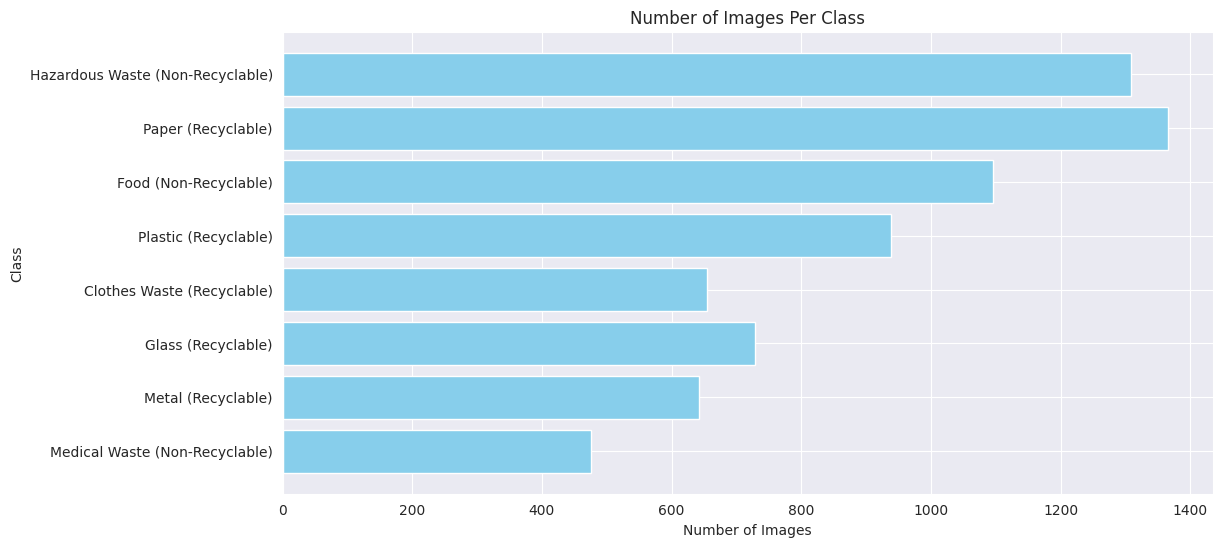

Class  Number of Images
0  Hazardous Waste (Non-Recyclable)              1308
1                Paper (Recyclable)              1366
2             Food (Non-Recyclable)              1096
3              Plastic (Recyclable)               939
4        Clothes Waste (Recyclable)               655
5                Glass (Recyclable)               729
6                Metal (Recyclable)               643
7    Medical Waste (Non-Recyclable)               475

In [8]:
class_names = data["names"]
num_classes = len(class_names)

class_counts = defaultdict(int)

# Loop through dataset splits and count images per class
for split in splits:
    labels_folder = os.path.join(dataset_path, split, "labels")

    if os.path.exists(labels_folder):
        for label_file in os.listdir(labels_folder):
            label_path = os.path.join(labels_folder, label_file)
            with open(label_path, "r") as file:
                for line in file.readlines():
                    class_id = int(line.split()[0])  # Get class index
                    class_counts[class_names[class_id]] += 1  # Increment count

df_class_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Number of Images"])

plt.figure(figsize=(12, 6))
plt.barh(df_class_counts["Class"], df_class_counts["Number of Images"], color="skyblue")
plt.xlabel("Number of Images")
plt.ylabel("Class")
plt.title("Number of Images Per Class")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

#Print the image counts per class
df_class_counts

In [9]:
# Load YOLOv8 model
model = YOLO("yolov8n.pt")

# Train the model
results = model.train(
    data="/kaggle/working/waste-classification8K-1/data.yaml",
    epochs=20,
    batch=16,
    imgsz=640,
    workers=2,
    device="cuda",
    augment=True,
    lr0= 0.001
)
#save the pretrained model
model.save("yolov8_trained_recyclable.pt")
print(" yolov8 model trained and saved")

100%|██████████| 6.25M/6.25M [00:00<00:00, 85.1MB/s]


Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/waste-classification8K-1/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=2, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.5MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/waste-classification8K-1/train/labels... 4156 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4156/4156 [00:04<00:00, 963.01it/s] 


train: New cache created: /kaggle/working/waste-classification8K-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /kaggle/working/waste-classification8K-1/valid/labels... 1169 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:01<00:00, 911.67it/s]


val: New cache created: /kaggle/working/waste-classification8K-1/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.2G     0.8397      2.612      1.325         39        640: 100%|██████████| 260/260 [00:51<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:08<00:00,  4.60it/s]


                   all       1169       1479        0.5      0.497      0.468      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.46G     0.8726      1.972      1.337         32        640: 100%|██████████| 260/260 [00:48<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.76it/s]


                   all       1169       1479      0.584      0.462      0.493      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.46G     0.9044      1.814      1.358         31        640: 100%|██████████| 260/260 [00:47<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.84it/s]


                   all       1169       1479      0.567      0.457      0.513      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.46G     0.8934      1.712      1.349         43        640: 100%|██████████| 260/260 [00:47<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.94it/s]


                   all       1169       1479      0.559      0.537      0.565      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.46G     0.8768      1.564      1.337         36        640: 100%|██████████| 260/260 [00:47<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.83it/s]

                   all       1169       1479      0.564      0.535      0.554      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.46G      0.855      1.484      1.321         36        640: 100%|██████████| 260/260 [00:47<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.87it/s]

                   all       1169       1479      0.671      0.595      0.649      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.46G     0.8449      1.403      1.309         37        640: 100%|██████████| 260/260 [00:48<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.97it/s]

                   all       1169       1479      0.603      0.643       0.65      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.46G     0.8286      1.361        1.3         46        640: 100%|██████████| 260/260 [00:47<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.81it/s]

                   all       1169       1479      0.683      0.658      0.695      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.46G     0.8061      1.281      1.286         38        640: 100%|██████████| 260/260 [00:48<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  6.07it/s]

                   all       1169       1479      0.673      0.676      0.724      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.46G      0.774      1.223      1.263         32        640: 100%|██████████| 260/260 [00:47<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  6.05it/s]

                   all       1169       1479      0.726      0.662      0.725      0.541


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.46G     0.6977      1.193      1.377         16        640: 100%|██████████| 260/260 [00:47<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.72it/s]

                   all       1169       1479      0.749      0.685      0.745      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.46G     0.6641      1.062      1.348         17        640: 100%|██████████| 260/260 [00:46<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  6.12it/s]

                   all       1169       1479      0.669       0.69      0.721      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.46G       0.63      0.998       1.32         14        640: 100%|██████████| 260/260 [00:46<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  6.10it/s]

                   all       1169       1479      0.755      0.722       0.78      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.46G     0.6128     0.9484      1.298         13        640: 100%|██████████| 260/260 [00:46<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.93it/s]

                   all       1169       1479      0.784      0.697      0.769      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.46G     0.5965     0.8765      1.278         14        640: 100%|██████████| 260/260 [00:46<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  6.18it/s]

                   all       1169       1479      0.807       0.69      0.785      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.46G     0.5704     0.8509      1.252         13        640: 100%|██████████| 260/260 [00:46<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  6.15it/s]

                   all       1169       1479      0.796      0.734      0.806      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.46G     0.5685     0.7659      1.249         12        640: 100%|██████████| 260/260 [00:47<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.97it/s]

                   all       1169       1479      0.769      0.749      0.815      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.46G     0.5481     0.7203      1.226         16        640: 100%|██████████| 260/260 [00:47<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  6.01it/s]

                   all       1169       1479      0.813      0.735      0.811      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.46G     0.5332     0.6827      1.215         15        640: 100%|██████████| 260/260 [00:47<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  6.16it/s]

                   all       1169       1479      0.832      0.747      0.825      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.46G     0.5204     0.6394      1.205         12        640: 100%|██████████| 260/260 [00:47<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.84it/s]

                   all       1169       1479      0.845      0.742      0.826       0.67



20 epochs completed in 0.302 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


                   all       1169       1479      0.824      0.763      0.836      0.691
Clothes Waste (Recyclable)        142        151      0.954      0.827      0.944      0.838
 Food (Non-Recyclable)        201        229      0.911      0.809      0.893      0.718
    Glass (Recyclable)        124        135      0.735      0.896      0.904       0.82
Hazardous Waste (Non-Recyclable)        245        280      0.929      0.791      0.875      0.696
Medical Waste (Non-Recyclable)         84         89      0.855      0.732      0.839      0.554
    Metal (Recyclable)        101        132      0.682      0.659      0.732      0.662
    Paper (Recyclable)        116        262       0.72      0.707       0.76      0.608
  Plastic (Recyclable)        163        201      0.805      0.679      0.742      0.628


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 5.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train
 yolov8 model trained and saved


Contents of /kaggle/working/runs:
runs/
    detect/
        train/
            R_curve.png
            val_batch1_pred.jpg
            confusion_matrix_normalized.png
            results.csv
            PR_curve.png
            args.yaml
            events.out.tfevents.1741772911.e3540f34a439.31.0
            confusion_matrix.png
            F1_curve.png
            val_batch1_labels.jpg
            results.png
            train_batch2.jpg
            train_batch2600.jpg
            val_batch2_pred.jpg
            train_batch1.jpg
            train_batch2602.jpg
            P_curve.png
            train_batch0.jpg
            val_batch0_pred.jpg
            val_batch0_labels.jpg
            labels_correlogram.jpg
            val_batch2_labels.jpg
            train_batch2601.jpg
            labels.jpg
            weights/
                last.pt
                best.pt


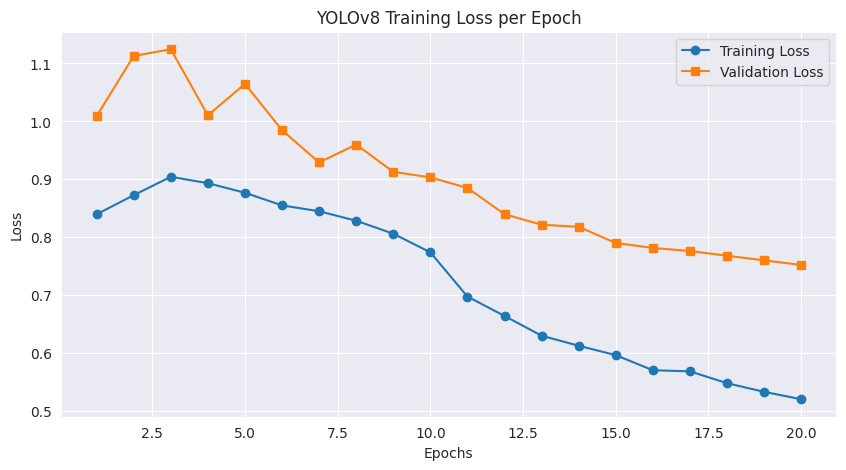

In [10]:
# Check if the runs directory exists and list its contents
runs_dir = "/kaggle/working/runs"
if os.path.exists(runs_dir):
    print(f"Contents of {runs_dir}:")
    for root, dirs, files in os.walk(runs_dir):
        level = root.replace(runs_dir, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{sub_indent}{f}")
else:
    print(f"The directory {runs_dir} does not exist.")

# Load the training results CSV
# Adjust the path according to where the results.csv is located in your Kaggle working directory
csv_path = "/kaggle/working/runs/detect/train/results.csv"  # Update this path if necessary
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    print(f"The file {csv_path} does not exist.")
    exit()

# Extract epochs and loss values
epochs = df.index + 1  # Epochs start from 1
train_loss = df["train/box_loss"]  # Training loss
val_loss = df["val/box_loss"]  # Validation loss

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, marker='o', label="Training Loss")
plt.plot(epochs, val_loss, marker='s', label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("YOLOv8 Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Save the trained model
model.save("yolov8_trained_recyclable.pt")
print(" Model trained on Recyclables and saved.")
model = YOLO("yolov8_trained_recyclable.pt")
metrics = model.val()
conf_matrix = metrics.confusion_matrix.matrix
print("Confusion Matrix Shape:", conf_matrix.shape)
# Print accuracy metrics
print(f"Validation Results:")
print(f"mAP@50: {metrics.box.map50:.4f}")       # mAP at 50% IoU
print(f"mAP@50-95: {metrics.box.map:.4f}")     # mAP at IoU range 50-95%
print(f"Precision: {metrics.box.mp:.4f}")      # Mean precision
print(f"Recall: {metrics.box.mr:.4f}")         # Mean recall

 Model trained on Recyclables and saved.
Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/waste-classification8K-1/valid/labels.cache... 1169 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1169/1169 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:08<00:00,  9.06it/s]


                   all       1169       1479      0.845      0.742      0.826      0.671
Clothes Waste (Recyclable)        142        151      0.941      0.821      0.925      0.796
 Food (Non-Recyclable)        201        229      0.914      0.787      0.891      0.694
    Glass (Recyclable)        124        135      0.792      0.889      0.898      0.806
Hazardous Waste (Non-Recyclable)        245        280      0.901      0.752      0.861      0.681
Medical Waste (Non-Recyclable)         84         89      0.845      0.737      0.826       0.57
    Metal (Recyclable)        101        132      0.808      0.644      0.719      0.634
    Paper (Recyclable)        116        262      0.756      0.672      0.738      0.584
  Plastic (Recyclable)        163        201      0.803      0.637      0.745      0.602


invalid value encountered in less
invalid value encountered in less


Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val
Confusion Matrix Shape: (9, 9)
Validation Results:
mAP@50: 0.8256
mAP@50-95: 0.6708
Precision: 0.8450
Recall: 0.7423



image 1/1 /kaggle/working/waste-classification8K-1/test/images/glass-571-_jpg.rf.c877d15a97dc5f9ade174be798c3439a.jpg: 640x640 1 Glass (Recyclable), 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


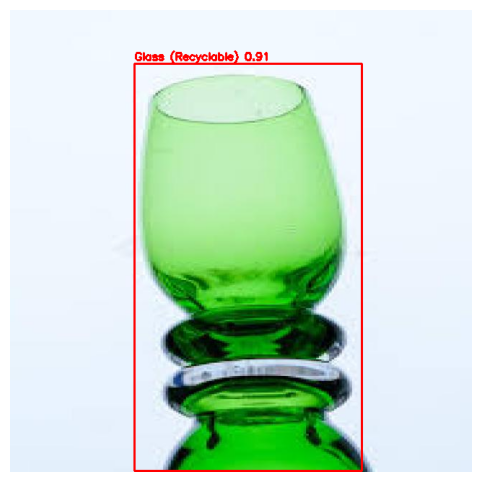


image 1/1 /kaggle/working/waste-classification8K-1/test/images/metal-432-_jpg.rf.08e5e237ca63e7eb10de705138690621.jpg: 640x640 1 Metal (Recyclable), 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


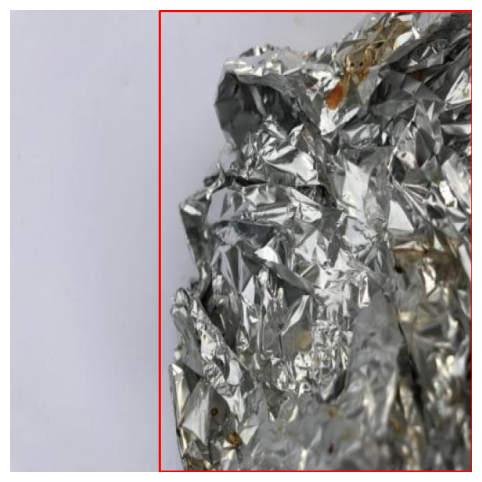


image 1/1 /kaggle/working/waste-classification8K-1/test/images/plastic-446-_jpg.rf.dadd14a12b7aff8c285d801a87be5ac3.jpg: 640x640 1 Plastic (Recyclable), 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


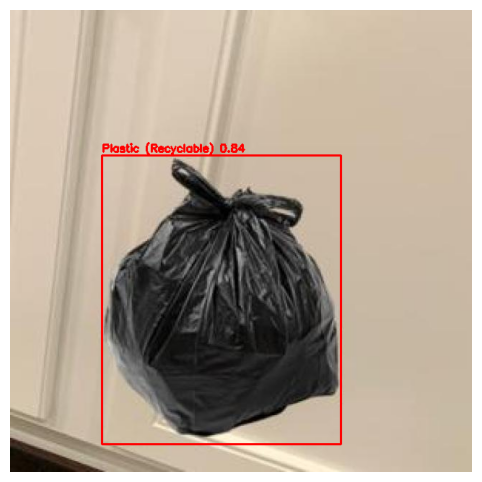


image 1/1 /kaggle/working/waste-classification8K-1/test/images/glass-443-_jpg.rf.2551e52685a4573489e9749da1283264.jpg: 640x640 1 Metal (Recyclable), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


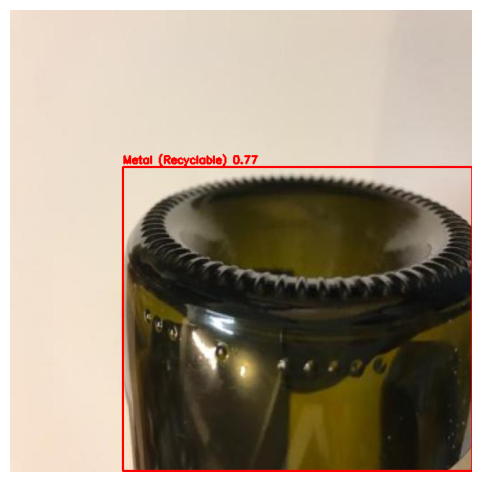


image 1/1 /kaggle/working/waste-classification8K-1/test/images/paper-462-_jpg.rf.eb64fe924c342f5bfcd85c00fdc2f03d.jpg: 640x640 1 Medical Waste (Non-Recyclable), 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


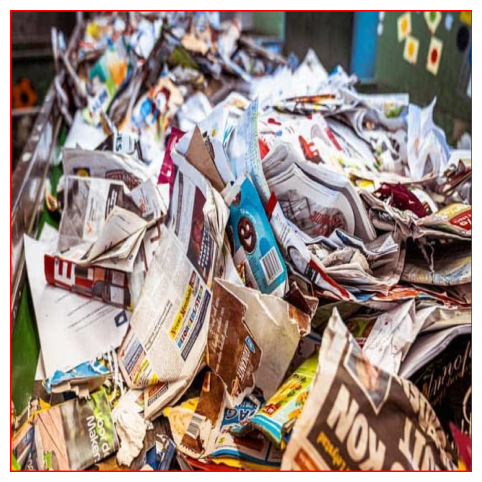


image 1/1 /kaggle/working/waste-classification8K-1/test/images/paper-409-_jpg.rf.f2c6d14a8525f2420413dd0652322f19.jpg: 640x640 1 Paper (Recyclable), 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


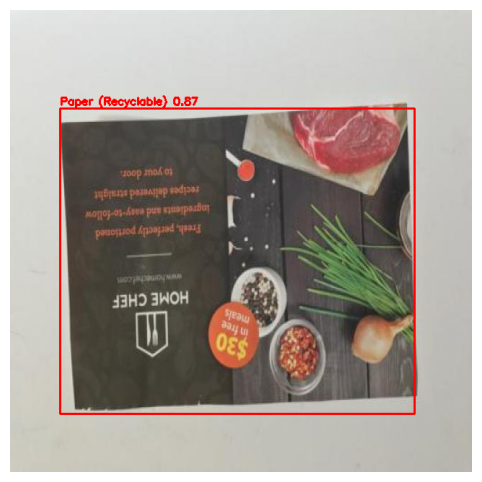


image 1/1 /kaggle/working/waste-classification8K-1/test/images/paper-277-_jpg.rf.c5776cb65157ee5cb2c9bf3d2a0c80a2.jpg: 640x640 1 Paper (Recyclable), 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


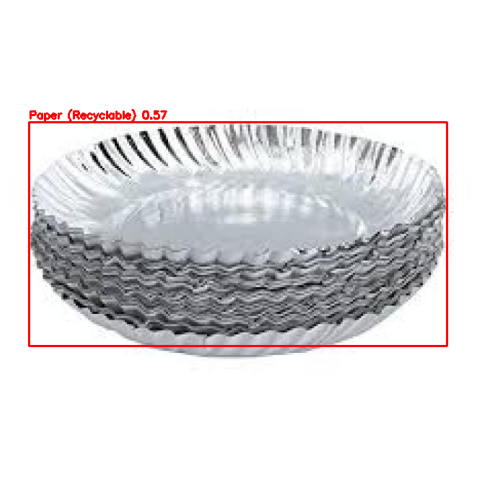


image 1/1 /kaggle/working/waste-classification8K-1/test/images/hzw-822-_jpg.rf.f83cc8c6481d402a8be9edf8b248e263.jpg: 640x640 1 Hazardous Waste (Non-Recyclable), 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


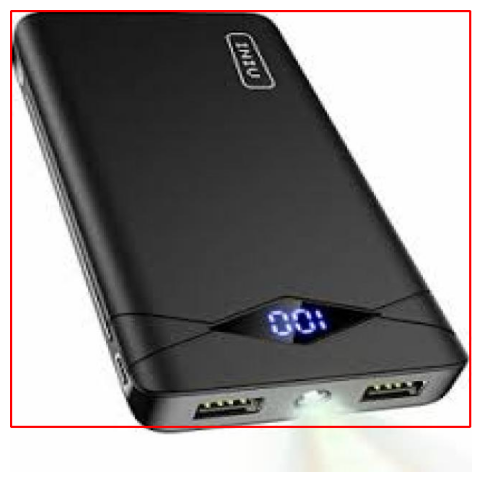


image 1/1 /kaggle/working/waste-classification8K-1/test/images/clothes-275-_jpg.rf.e0da4db9e8865d8aaf85f63943f44cfb.jpg: 640x640 1 Clothes Waste (Recyclable), 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


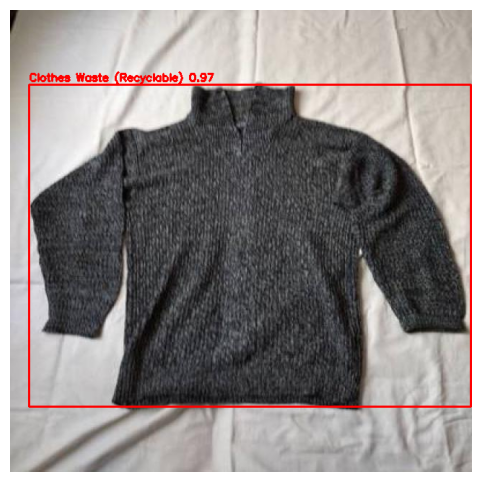


image 1/1 /kaggle/working/waste-classification8K-1/test/images/plastic-441-_jpg.rf.35c8cd37c71c71fd42656bcd27ffcbe1.jpg: 640x640 3 Plastic (Recyclable)s, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


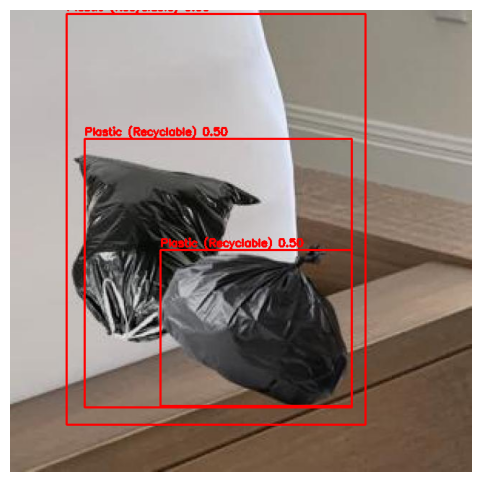

In [37]:
import glob
# Get a few sample test images
test_images = glob.glob("/kaggle/working/waste-classification8K-1/test/images/*.jpg")[40:50]

# Run inference and visualize results
for img_path in test_images:
    results = model(img_path)  

    # Convert results 
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    # Draw bounding boxes
    for result in results:
        for box in result.boxes.xyxy: 
            x1, y1, x2, y2 = map(int, box[:4])  # Get bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw box
            label = f"{model.names[int(result.boxes.cls[0])]} {result.boxes.conf[0]:.2f}"  # Label + Confidence
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display images
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

helper functions:

**extract_features** is used to extract features from yolov8 convolutional layer (6 in this case).

**visualize_pca_projection** uses PCA to visualize classes projected in 2D with colour mapping

**display_random_batch** to test images with predictions

In [30]:
def extract_features_with_labels(model, image_dir, label_dir, layer_index=6, resize_dim=(320, 320)):
    """
    Extract features and labels from images using corresponding label files.
    
    Args:
        model: Trained YOLOv8 model.
        image_dir: Directory containing images.
        label_dir: Directory containing YOLO-format label text files.
        layer_index: Index of the model layer to extract features from.
        resize_dim: Tuple for image resizing (width, height).
    
    Returns:
        features: Numpy array of extracted features.
        raw_labels: List of class names for each image.
        class_names: Same as raw_labels (for backward compatibility).
    """
    device = next(model.parameters()).device
    features_list = []
    raw_labels = []  # This will hold the human-readable class names

    # List images (sorted for consistency)
    image_paths = sorted([os.path.join(image_dir, f) 
                          for f in os.listdir(image_dir) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    for image_path in image_paths:
        # Construct the corresponding label file path (assumes same basename with .txt)
        base = os.path.splitext(os.path.basename(image_path))[0]
        label_file = os.path.join(label_dir, base + ".txt")
        if os.path.exists(label_file):
            with open(label_file, "r") as f:
                lines = f.readlines()
            if lines:
                # Assuming one label per image (or take the first label if multiple exist)
                tokens = lines[0].strip().split()
                try:
                    cls_id = int(tokens[0])
                    # Map the class id to the corresponding name from new_names
                    label = new_names[cls_id] if cls_id < len(new_names) else "Unknown"
                except Exception as e:
                    print(f"Error parsing label from {label_file}: {e}")
                    label = "Unknown"
            else:
                label = "Unknown"
        else:
            print(f"Label file not found for image: {image_path}")
            label = "Unknown"
        
        # Append the label
        raw_labels.append(label)

        # Load and preprocess image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read {image_path}")
            continue
        if resize_dim:
            img = cv2.resize(img, resize_dim)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0
        img_tensor = img_tensor.unsqueeze(0).to(device)

        # Forward pass through the model up to the desired layer
        with torch.no_grad():
            x = img_tensor
            for j in range(layer_index + 1):
                x = model.model.model[j](x)
            features = x.flatten().cpu().numpy()
        features_list.append(features)

        # Free memory for each image if needed
        gc.collect()
        if device.type == "cuda":
            torch.cuda.empty_cache()

    features = np.array(features_list)
    # Here we set class_names to be the same as raw_labels, which can be used for visualization.
    return features, raw_labels, raw_labels


def visualize_pca_projection(features, encoded_labels, raw_labels):
    """
    Visualize 2D PCA projection of features with class color coding.
    
    Args:
        features: Feature vectors.
        encoded_labels: Numerical labels.
        raw_labels: Raw labels (used to get a representative class name).
    """
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features_scaled)

    plt.figure(figsize=(14, 10))
    unique_labels = np.unique(encoded_labels)
    cmap = plt.cm.get_cmap('tab10', len(unique_labels))

    for label in unique_labels:
        idx = np.where(encoded_labels == label)[0]
        if idx.size == 0:
            continue
        # Use the first occurrence for naming
        class_name = raw_labels[idx[0]]
        plt.scatter(principal_components[idx, 0],
                    principal_components[idx, 1],
                    c=[cmap(label)],
                    label=class_name,
                    alpha=0.7,
                    edgecolor='w',
                    s=60)
    
    plt.title('2D PCA Projection of YOLOv8 Features', pad=20)
    plt.xlabel('Principal Component 1', labelpad=10)
    plt.ylabel('Principal Component 2', labelpad=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Classes')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def display_random_batch(test_df, test_labels, test_predictions, label_encoder, batch_size=10):
   
    random_indices = np.random.choice(len(test_df), size=batch_size, replace=False)
    fig, axes = plt.subplots(2, batch_size // 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, idx in enumerate(random_indices):
        img_path = test_df.iloc[idx]['filepaths']
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        
        if img is None:
            print(f"Warning: Unable to read image {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        true_label = test_labels[idx]
        predicted_label = test_predictions[idx]
        true_class = label_encoder.inverse_transform([true_label])[0]
        predicted_class = label_encoder.inverse_transform([predicted_label])[0]

        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_class}\nPred: {predicted_class}", fontsize=10,
                          color="green" if true_class == predicted_class else "red")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Random Forest workflow

In [19]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Hyperparameter tuning with RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=8,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_scaled, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Train the best model
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
Best cross-validation score: 0.6275571600481348


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


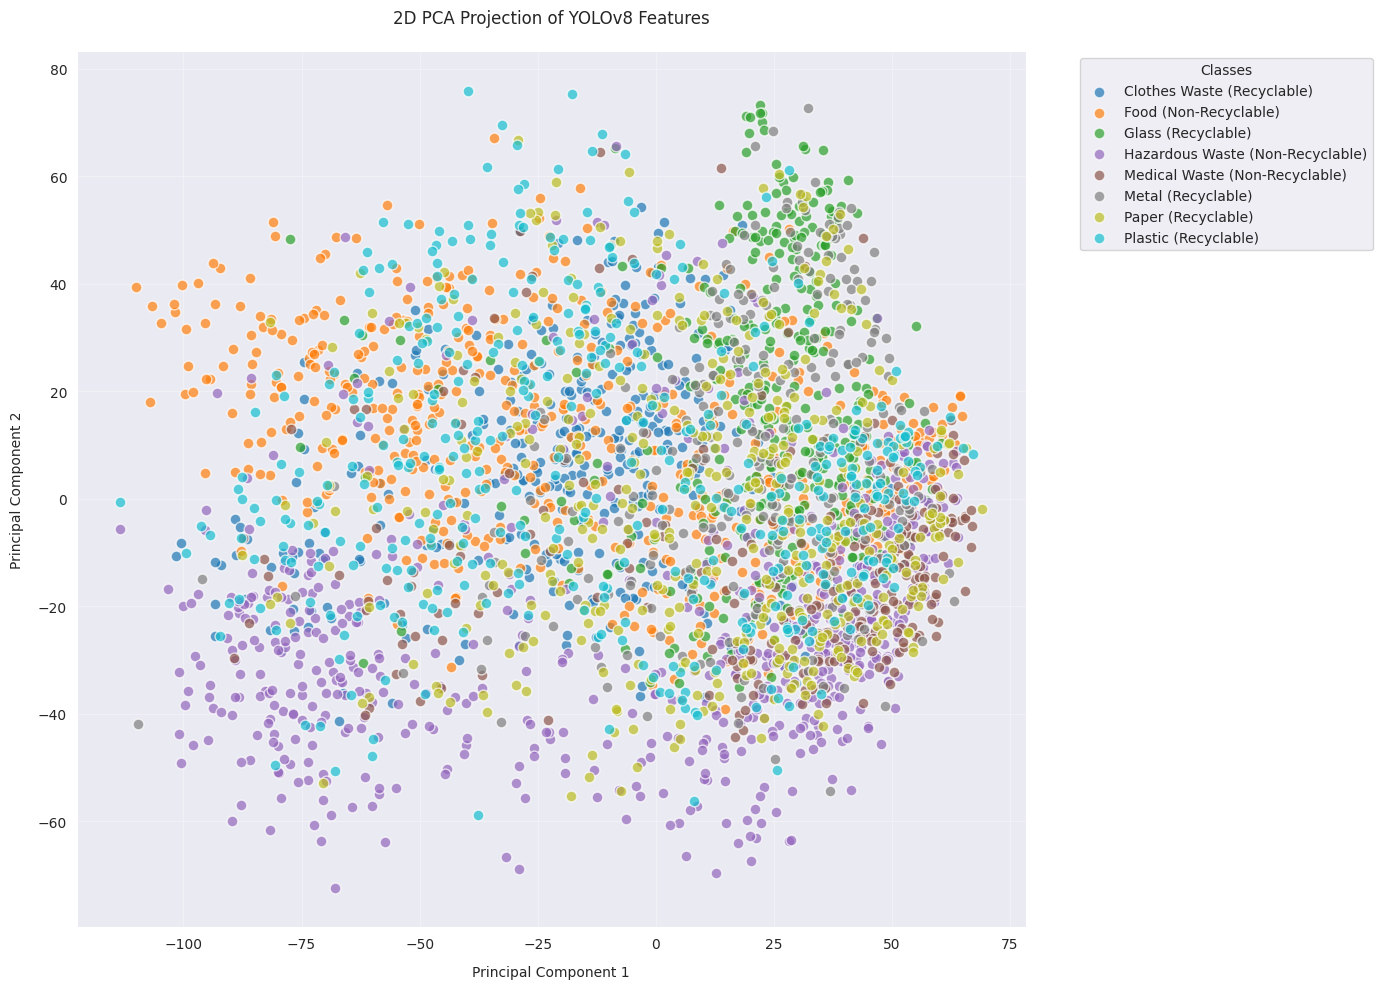

In [16]:
# Paths and configuration
train_image_dir = "/kaggle/working/waste-classification8K-1/train/images"
train_label_dir = "/kaggle/working/waste-classification8K-1/train/labels"  # Define train label directory
test_image_dir = "/kaggle/working/waste-classification8K-1/test/images"
test_label_dir = "/kaggle/working/waste-classification8K-1/test/labels"    # Define test label directory
layer_index = 6

# --- Feature extraction on training images ---
features, raw_labels, class_names = extract_features_with_labels(model, train_image_dir, train_label_dir, layer_index=layer_index)
if features.size == 0:
    raise ValueError("No valid features extracted from training images. Check the image paths and layer index.")
    
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(raw_labels)

# Split the data into training and validation sets (stratified)
X_train, X_val, y_train, y_val, raw_train, raw_val = train_test_split(
    features, labels_encoded, raw_labels, test_size=0.2, random_state=42, stratify=labels_encoded
)

# Visualize PCA projection on training data using the correctly aligned raw labels
visualize_pca_projection(X_train, y_train, raw_train)

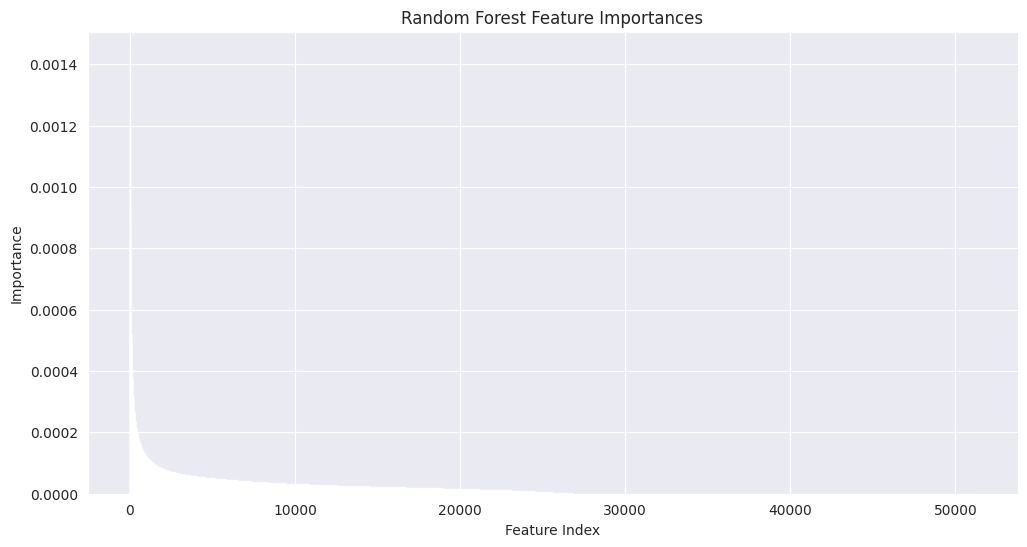

In [22]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Create the plot
plt.figure(figsize=(12, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center", color='red')
plt.xlabel("Feature Index")
plt.ylabel("Importance")

# Set y-axis limits to better visualize the bars
plt.ylim(0, max(importances) * 1.1)

plt.show()

Validation Accuracy: 0.640625
Validation Classification Report:
                                   precision    recall  f1-score   support

      Clothes Waste (Recyclable)       0.61      0.71      0.66        84
           Food (Non-Recyclable)       0.71      0.93      0.81       137
              Glass (Recyclable)       0.53      0.59      0.56        93
Hazardous Waste (Non-Recyclable)       0.66      0.84      0.74       166
  Medical Waste (Non-Recyclable)       0.64      0.63      0.64        65
              Metal (Recyclable)       0.70      0.39      0.50        71
              Paper (Recyclable)       0.62      0.36      0.46       110
            Plastic (Recyclable)       0.57      0.40      0.47       106

                        accuracy                           0.64       832
                       macro avg       0.63      0.61      0.60       832
                    weighted avg       0.64      0.64      0.62       832



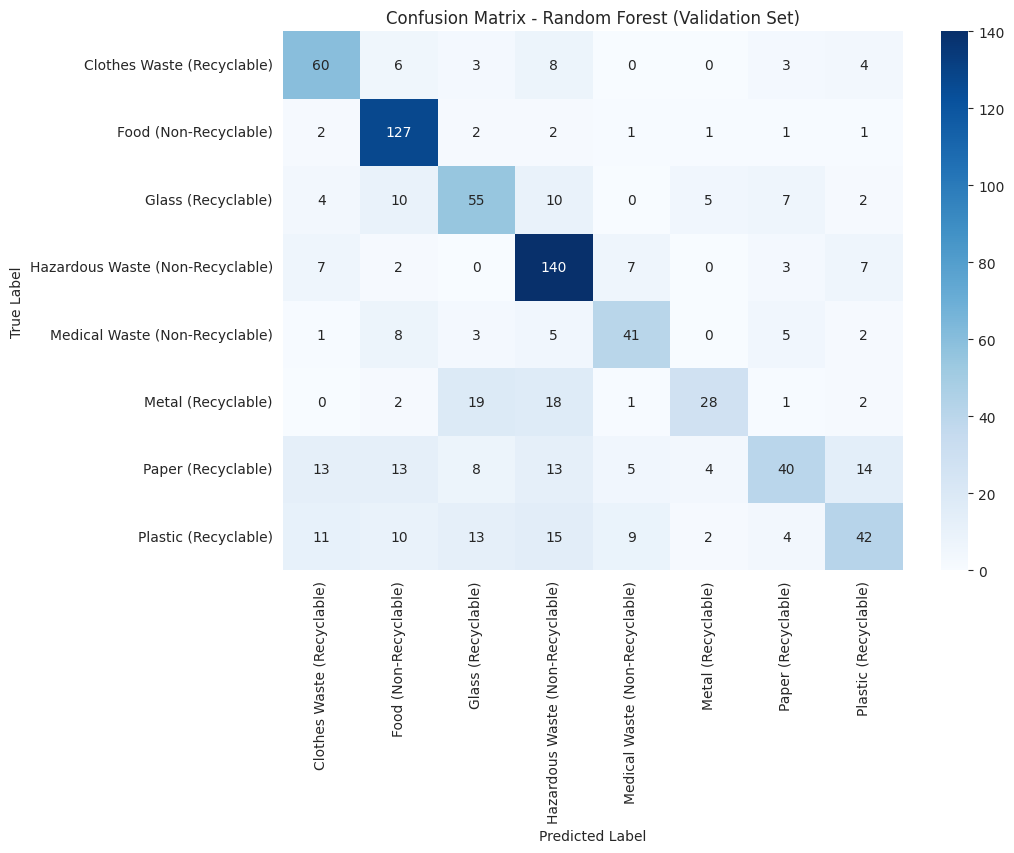

['label_encoder.pkl']

In [59]:
# --- Evaluation on Validation Set ---
y_val_pred = best_rf_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest (Validation Set)")
plt.show()

joblib.dump(best_rf_model, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

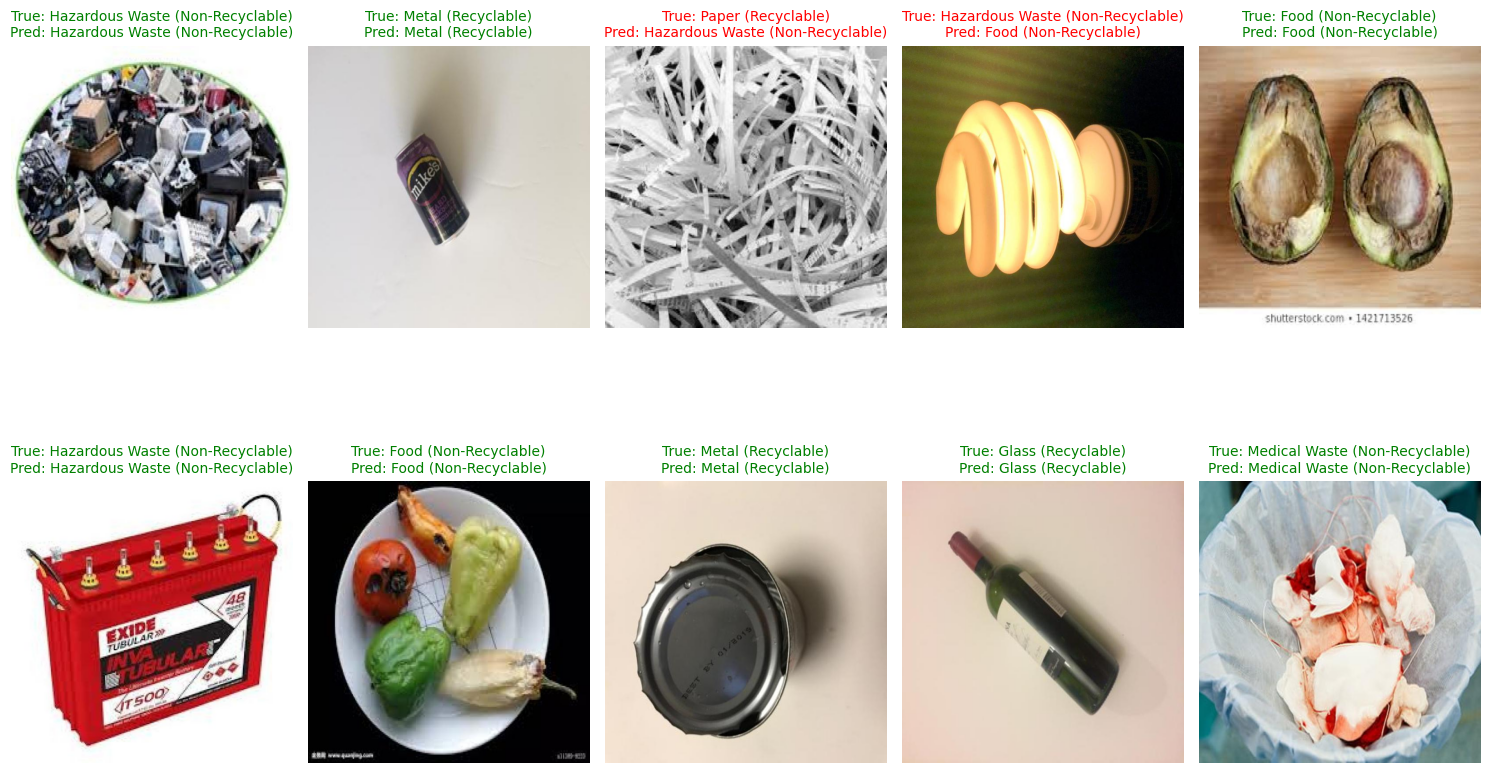

Feature Shape: (4156, 51200)
Feature Min: -0.2784646
Feature Max: 12.1721
Feature Mean: 0.012455783
Feature Std: 0.39405125
Min Feature Magnitude: 72.568405
Max Feature Magnitude: 122.96919
Mean Feature Magnitude: 89.00041


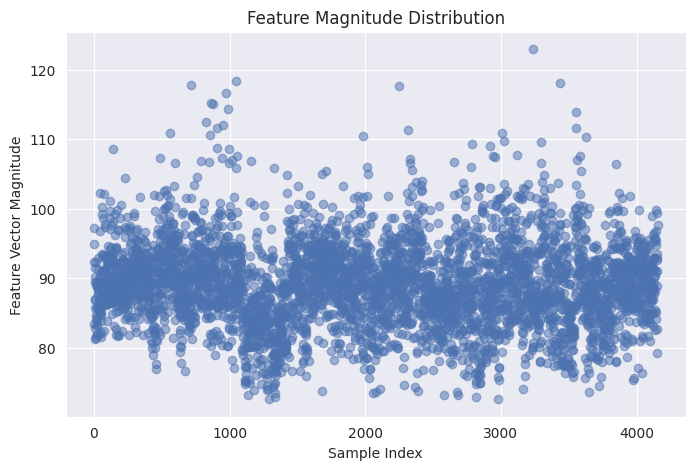

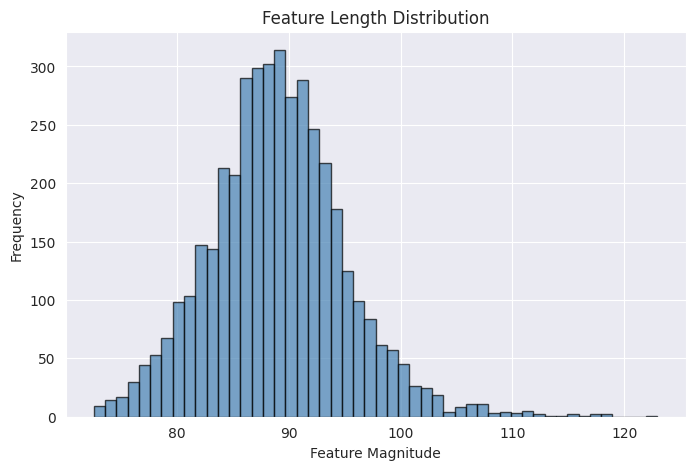

In [41]:
# --- Display random batch of test images with predictions ---
test_image_paths = sorted([
    os.path.join(test_image_dir, f) 
    for f in os.listdir(test_image_dir) 
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])
test_df = pd.DataFrame({'filepaths': test_image_paths})
display_random_batch(test_df, test_labels_encoded, y_test_pred, label_encoder, batch_size=10)

# --- Feature statistics ---
print("Feature Shape:", features.shape)
print("Feature Min:", np.min(features))
print("Feature Max:", np.max(features))
print("Feature Mean:", np.mean(features))
print("Feature Std:", np.std(features))

feature_lengths = np.linalg.norm(features, axis=1)
print("Min Feature Magnitude:", np.min(feature_lengths))
print("Max Feature Magnitude:", np.max(feature_lengths))
print("Mean Feature Magnitude:", np.mean(feature_lengths))

plt.figure(figsize=(8, 5))
plt.plot(feature_lengths, 'bo', alpha=0.5)
plt.xlabel("Sample Index")
plt.ylabel("Feature Vector Magnitude")
plt.title("Feature Magnitude Distribution")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(feature_lengths, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel("Feature Magnitude")
plt.ylabel("Frequency")
plt.title("Feature Length Distribution")
plt.grid(True)
plt.show()

Test Accuracy: 0.6314878892733564
Test Classification Report:
                                   precision    recall  f1-score   support

      Clothes Waste (Recyclable)       0.68      0.78      0.72        54
           Food (Non-Recyclable)       0.73      0.94      0.82        83
              Glass (Recyclable)       0.55      0.68      0.61        63
Hazardous Waste (Non-Recyclable)       0.61      0.78      0.68       120
  Medical Waste (Non-Recyclable)       0.72      0.55      0.63        47
              Metal (Recyclable)       0.66      0.36      0.46        53
              Paper (Recyclable)       0.60      0.47      0.53        72
            Plastic (Recyclable)       0.54      0.34      0.41        86

                        accuracy                           0.63       578
                       macro avg       0.63      0.61      0.61       578
                    weighted avg       0.63      0.63      0.61       578



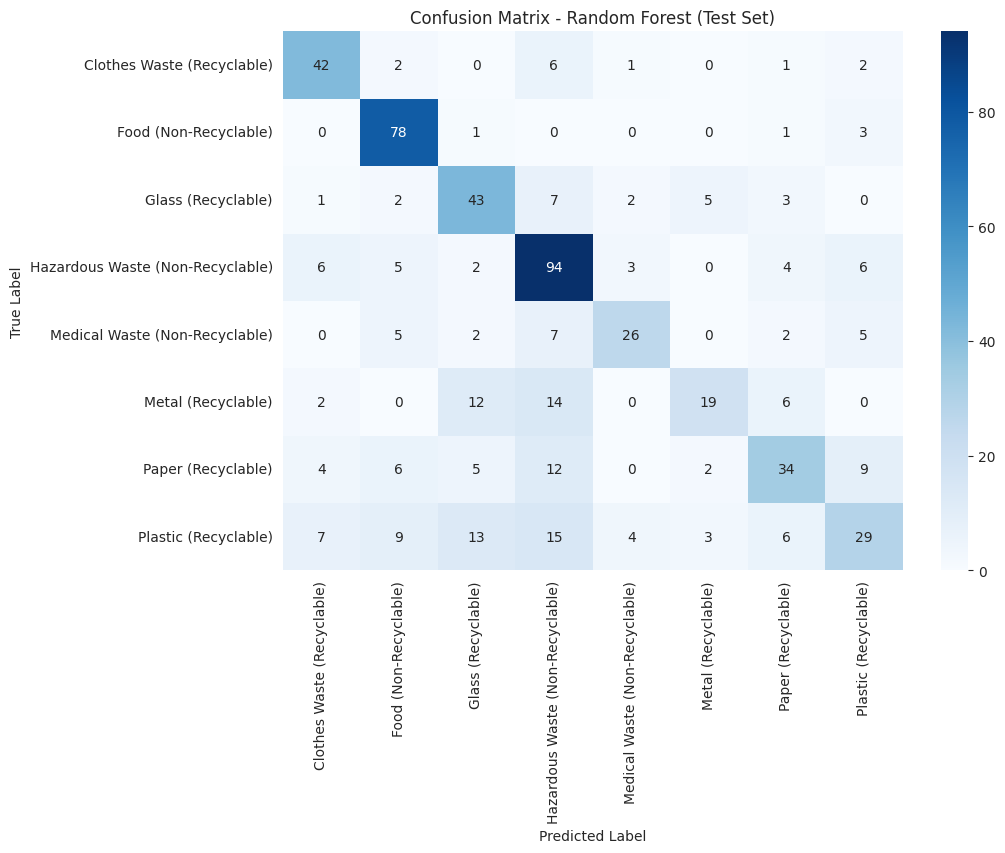

In [28]:
# --- Feature extraction and evaluation on Test Set ---
test_features, test_raw_labels, class_names = extract_features_with_labels(model, test_image_dir, test_label_dir, layer_index=layer_index)
if test_features.size == 0:
    raise ValueError("No valid features extracted from test images. Check the image paths and layer index.")
test_labels_encoded = label_encoder.transform(test_raw_labels)
test_features_scaled = scaler.transform(test_features)

y_test_pred = best_rf_model.predict(test_features_scaled)
print("Test Accuracy:", accuracy_score(test_labels_encoded, y_test_pred))
print("Test Classification Report:\n", classification_report(test_labels_encoded, y_test_pred, target_names=label_encoder.classes_))

# Plot confusion matrix for test set
cm_test = confusion_matrix(test_labels_encoded, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest (Test Set)")
plt.show()

SVM workflow, to provide a basis for comparison we use the same feature extractions and processes as training the Random Forest classifier

In [43]:
pca_2d = PCA(n_components=2)
X_train_pca = pca_2d.fit_transform(X_train)

#compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

#pipeline that includes scaling, PCA and SVM
pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.93),  # Retain 93% variance; this will be tuned.
    SVC(probability=True, class_weight=class_weight_dict, random_state=42)
)

param_grid = {
    'pca__n_components': [0.90, 0.93, 0.95],  # Variance thresholds to try.
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1, 10],
    'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'svc__degree': [3, 4]  # Only used if kernel is 'poly'
}

# Set up RandomizedSearchCV with 5-fold stratified cross-validation.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=12,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

# Create a mesh to plot in
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'svc__kernel': 'linear', 'svc__gamma': 10, 'svc__degree': 4, 'svc__C': 10, 'pca__n_components': 0.93}
Best cross-validation score: 0.7975337439985506


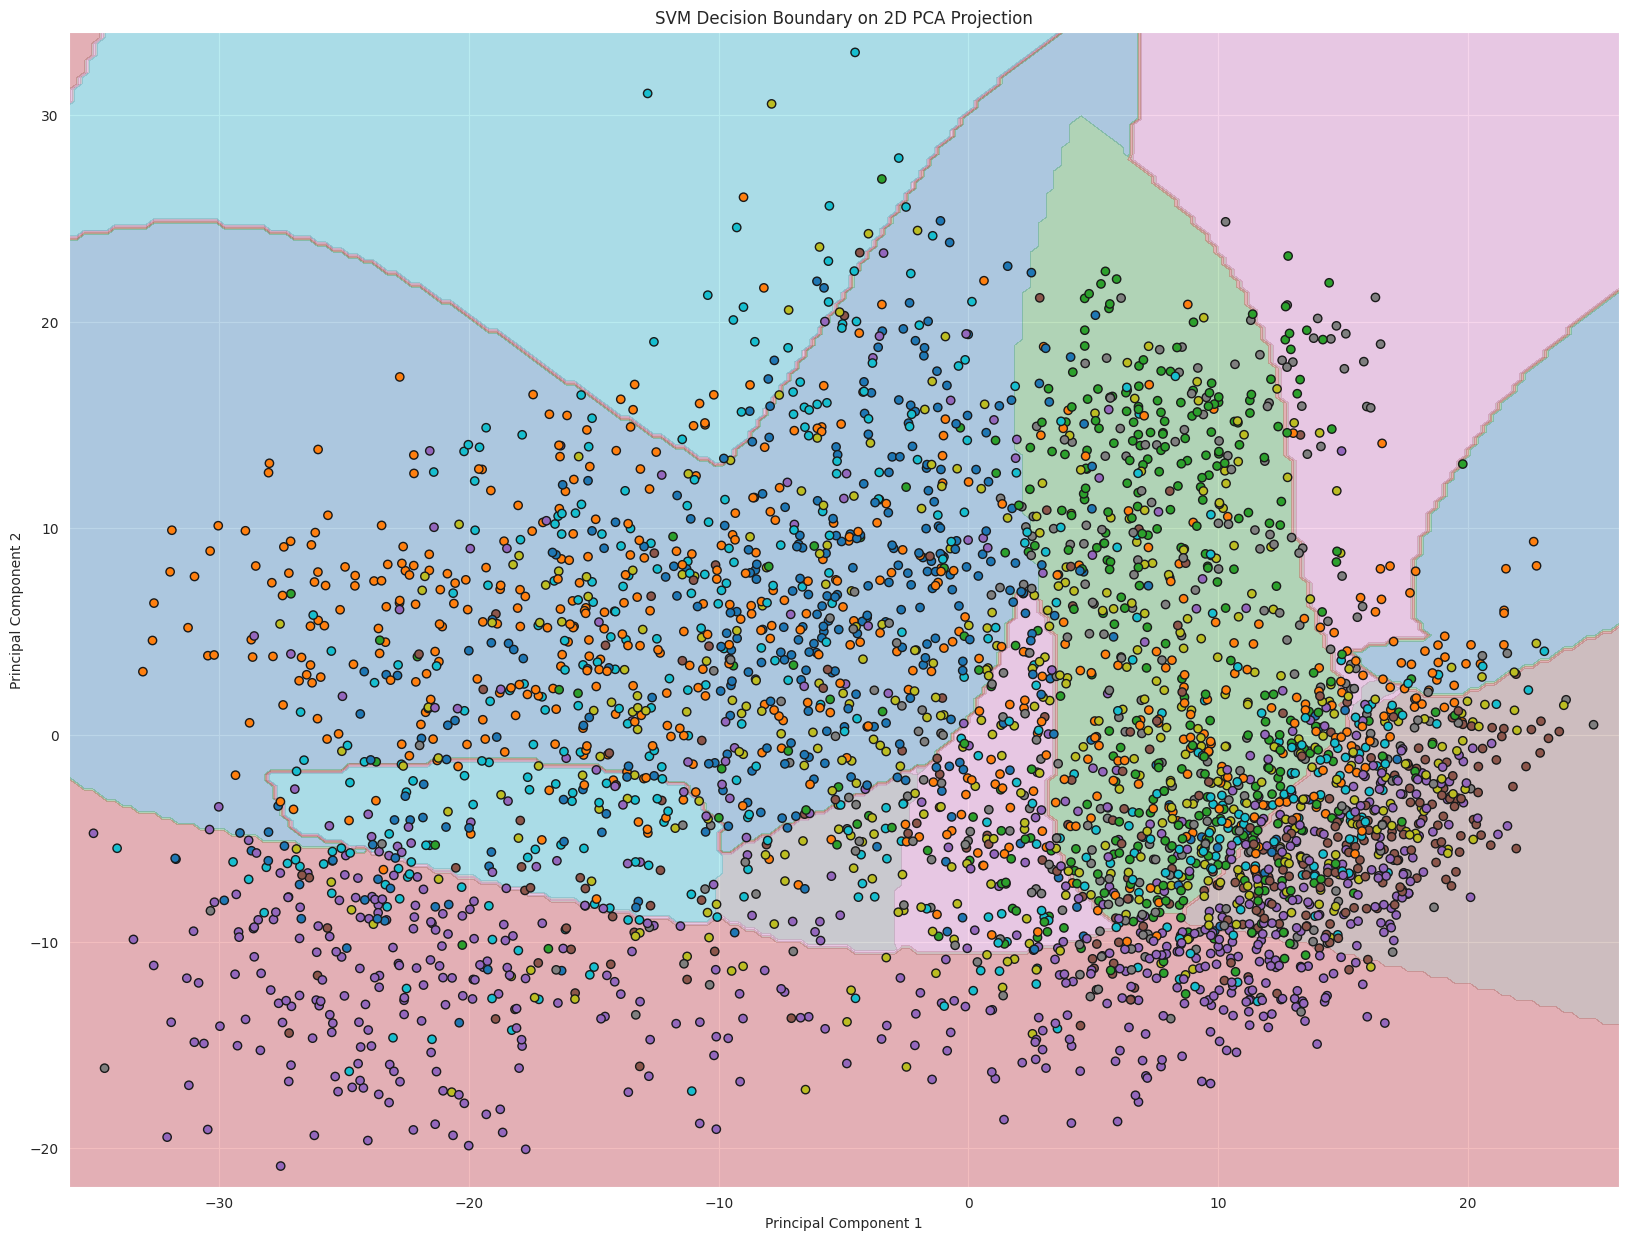

In [48]:
best_svm_model = random_search.best_estimator_


svm_2d = SVC(probability=True, class_weight=best_svm_model.named_steps['svc'].class_weight, random_state=42) # Train SVM directly on the 2D PCA features
svm_2d.fit(X_train_pca, y_train)

# Predict on the mesh grid
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(20, 15))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.tab10)
# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.tab10, edgecolors='k')
plt.title("SVM Decision Boundary on 2D PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Validation Accuracy: 0.8233173076923077
Validation Classification Report:
                                   precision    recall  f1-score   support

      Clothes Waste (Recyclable)       0.90      0.83      0.86        84
           Food (Non-Recyclable)       0.92      0.96      0.94       137
              Glass (Recyclable)       0.76      0.83      0.79        93
Hazardous Waste (Non-Recyclable)       0.82      0.94      0.87       166
  Medical Waste (Non-Recyclable)       0.78      0.77      0.78        65
              Metal (Recyclable)       0.88      0.69      0.77        71
              Paper (Recyclable)       0.76      0.69      0.72       110
            Plastic (Recyclable)       0.77      0.71      0.74       106

                        accuracy                           0.82       832
                       macro avg       0.82      0.80      0.81       832
                    weighted avg       0.82      0.82      0.82       832



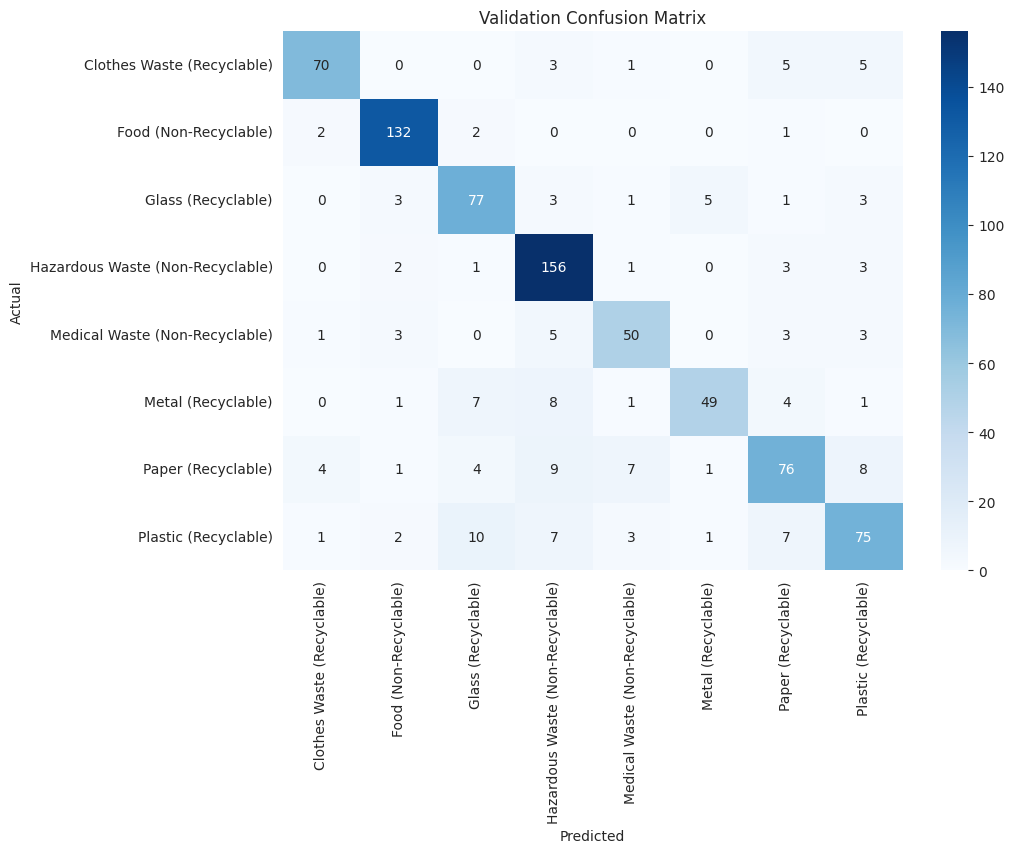

['label_encoder.pkl']

In [61]:
#evaluate on the validation set
X_val_scaled = random_search.best_estimator_.named_steps['standardscaler'].transform(X_val)
y_val_pred = random_search.best_estimator_.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", 
      classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

# Plot confusion matrix for validation set
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")
plt.show()

joblib.dump(random_search.best_estimator_, 'svm_best_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

Test Accuracy: 0.7179930795847751
Test Classification Report:
                                   precision    recall  f1-score   support

      Clothes Waste (Recyclable)       0.62      0.93      0.75        54
           Food (Non-Recyclable)       0.78      0.94      0.85        83
              Glass (Recyclable)       0.76      0.70      0.73        63
Hazardous Waste (Non-Recyclable)       0.72      0.83      0.77       120
  Medical Waste (Non-Recyclable)       0.68      0.64      0.66        47
              Metal (Recyclable)       0.77      0.57      0.65        53
              Paper (Recyclable)       0.89      0.46      0.61        72
            Plastic (Recyclable)       0.62      0.58      0.60        86

                        accuracy                           0.72       578
                       macro avg       0.73      0.71      0.70       578
                    weighted avg       0.73      0.72      0.71       578



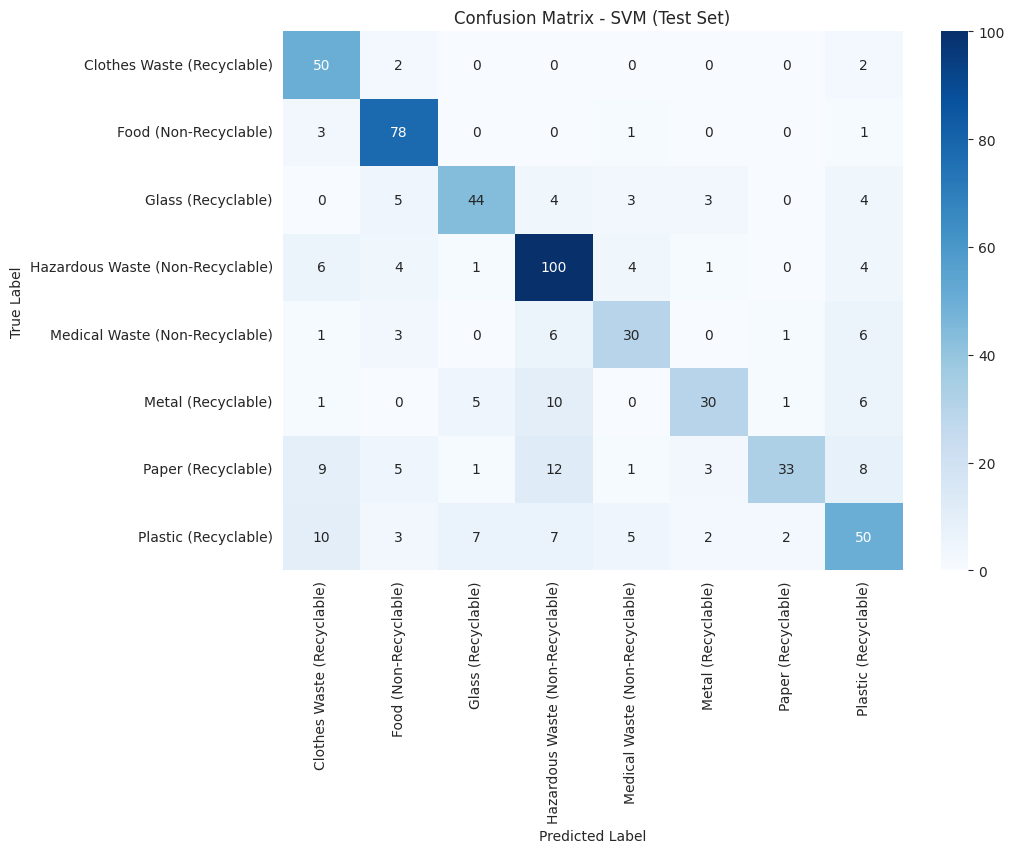

In [64]:
loaded_model = joblib.load('svm_best_model.pkl')
scaler_loaded = loaded_model.named_steps['standardscaler']
test_features_scaled = scaler_loaded.transform(test_features)

y_test_pred = loaded_model.predict(test_features_scaled)
print("Test Accuracy:", accuracy_score(test_labels_encoded, y_test_pred))
print("Test Classification Report:\n", 
      classification_report(test_labels_encoded, y_test_pred, target_names=label_encoder.classes_))

conf_matrix_test = confusion_matrix(test_labels_encoded, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM (Test Set)")
plt.show()

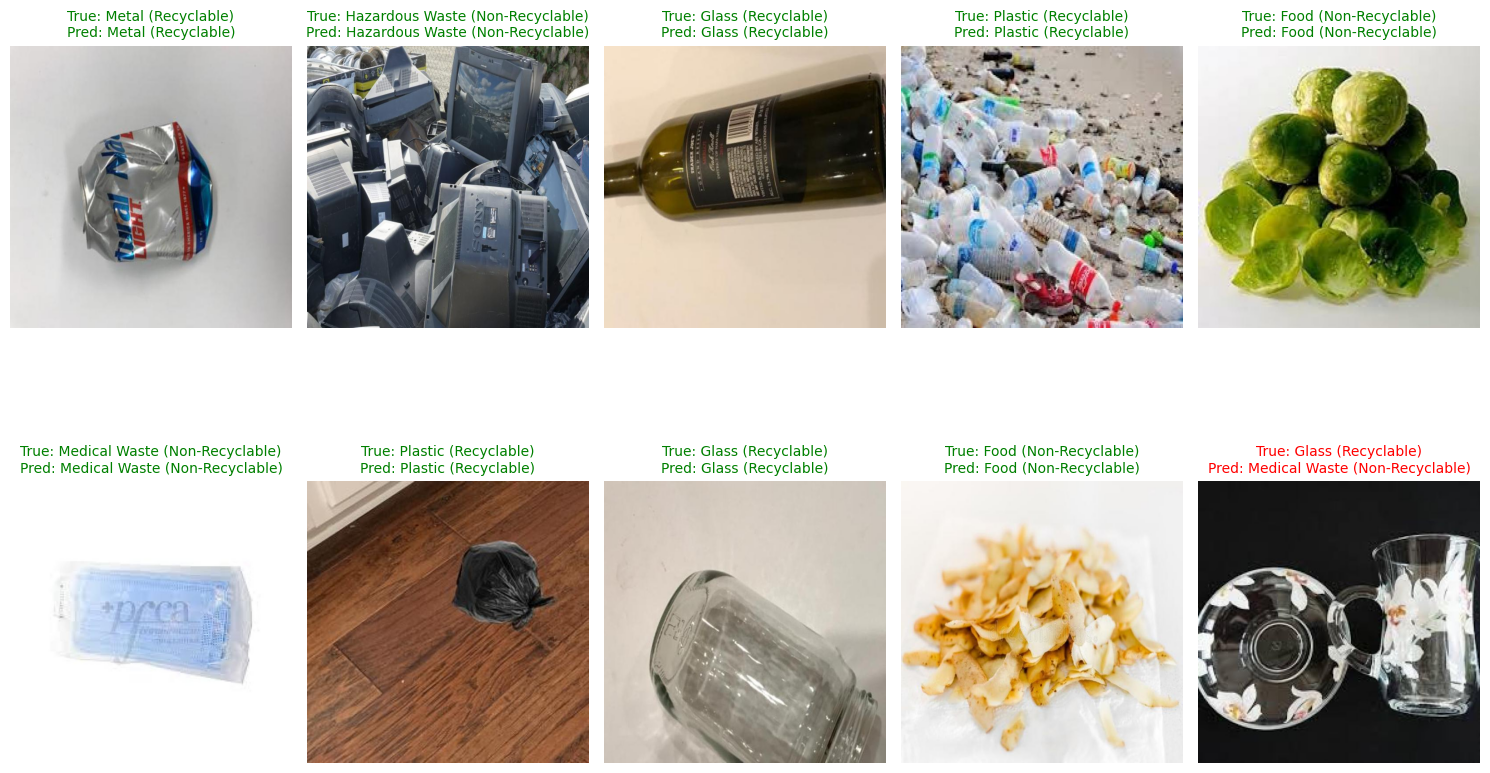

In [65]:
test_image_paths = sorted([
    os.path.join(test_image_dir, f) 
    for f in os.listdir(test_image_dir) 
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])
test_df = pd.DataFrame({'filepaths': test_image_paths})
display_random_batch(test_df, test_labels_encoded, y_test_pred, label_encoder, batch_size=10)